In [1]:
import sys
print(sys.executable)

/home/hosseinsh/venvs/nlp310/bin/python


In [2]:
import sys
import subprocess

# List of required packages
packages = [
    "torch",
    "torchvision",
    "pillow",
    "matplotlib",
    "tqdm",
    "peft",
    "transformers"
]

# Install each package
for pkg in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", pkg])

  Using cached torch-2.8.0-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cufft_cu12-11.3.3.83-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadat

In [2]:
!python --version

Python 3.10.18


In [4]:
!pip install gdown

In [6]:
!gdown "https://drive.google.com/uc?id=1MuH6XKakAgLMKm1LjSfjbgrms8fqpZUR" -O dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1MuH6XKakAgLMKm1LjSfjbgrms8fqpZUR
From (redirected): https://drive.google.com/uc?id=1MuH6XKakAgLMKm1LjSfjbgrms8fqpZUR&confirm=t&uuid=b07e1519-d8bd-4ba6-adf9-9d7fd56eca10
To: /home/hosseinsh/jupyterNotes/dataset.zip
100%|██████████████████████████████████████| 3.37G/3.37G [13:42<00:00, 4.09MB/s]
unzip:  cannot find or open product_images_extended.zip, product_images_extended.zip.zip or product_images_extended.zip.ZIP.


In [10]:
!gdown "https://drive.google.com/uc?id=1IAOR91bV1zCLFa9Bu_tIomshLH4QLzoA" -O products.json

Downloading...
From: https://drive.google.com/uc?id=1IAOR91bV1zCLFa9Bu_tIomshLH4QLzoA
To: /home/hosseinsh/jupyterNotes/product_S.json
100%|██████████████████████████████████████| 3.15M/3.15M [00:01<00:00, 1.69MB/s]


In [7]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: product_images/
  inflating: product_images/1000964.jpg  
  inflating: product_images/1000964_0.jpg  
  inflating: product_images/1000964_1.jpg  
  inflating: product_images/1001571.jpg  
  inflating: product_images/1001571_0.jpg  
  inflating: product_images/1001571_1.jpg  
  inflating: product_images/1001670.jpg  
  inflating: product_images/1001670_0.jpg  
  inflating: product_images/1001670_1.jpg  
  inflating: product_images/1001670_2.jpg  
  inflating: product_images/1001690.jpg  
  inflating: product_images/1001690_0.jpg  
  inflating: product_images/1001690_1.jpg  
  inflating: product_images/1002554.jpg  
  inflating: product_images/1002554_0.jpg  
  inflating: product_images/1002554_2.jpg  
  inflating: product_images/1002608.jpg  
  inflating: product_images/1002608_2.jpg  
  inflating: product_images/1002645.jpg  
  inflating: product_images/1002645_0.jpg  
  inflating: product_images/1002645_1.jpg  
  inflating: product_images/1002645_2.j

## Start of Code

In [2]:
import torch
from torch import optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

import subprocess
import os
import json
import random

from peft import get_peft_model, LoraConfig, TaskType

In [3]:
torch.cuda.set_device(1) 
print(torch.cuda.current_device())

1


In [4]:
if torch.cuda.is_available():
    current_device_index = torch.cuda.current_device()
    print(f"Current CUDA device index: {current_device_index}")
    device_name = torch.cuda.get_device_name(current_device_index)
    print(f"Current CUDA device name: {device_name}")
else:
    print("CUDA is not available on this system.")

Current CUDA device index: 1
Current CUDA device name: NVIDIA A100-SXM4-40GB


In [5]:
device = f"cuda:{torch.cuda.current_device()}"
device

'cuda:1'

In [6]:
def unzip(input_path: str, output_path: str):
  subprocess.run(["unzip", input_path, "-d", output_path])

def copy(input_path: str, output_path: str):
  subprocess.run(["cp", input_path, output_path])

def remove(input_path: str, dir=False):
  subprocess.run(["rm", "-r" if dir else "", input_path])

In [7]:
def read_and_filter_products(path: str, images_path: str, max_images=3):
  supported_formats = [".jpg"]

  with open(path, "r") as f:
    products = json.load(f)

  filtered_products = []
  for product in products:
    product_id = product["product_id"]

    images = []
    names = [product_id] + [f"{product_id}_{i}" for i in range(max_images)]
    for name in names:
      for ext in supported_formats:
        if os.path.isfile(f"{images_path}{name}{ext}"):
          images.append(f"{images_path}{name}{ext}")
          break

    if len(images) != 0:
      filtered_products.append({
        "product_id": product["product_id"],
        "summary": product["summary"],
        "images": images
      })

  return filtered_products

In [8]:
def remove_corrupted(products):
  image_transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
  ])

  for product in tqdm(products):
    for image in product["images"]:
      try:
        image_transform(Image.open(image))
      except:
        print("dropped:", image)
        remove(image)

filtered_products = read_and_filter_products("products.json", "./product_images/")
remove_corrupted(filtered_products)

  0%|          | 0/2034 [00:00<?, ?it/s]

In [9]:
def unnormalize_image(image, mean, std):
  mean = torch.tensor(mean).view(3, 1, 1)
  std = torch.tensor(std).view(3, 1, 1)

  image = image * std + mean
  image = transforms.ToPILImage()(image)

  return image

## **PRODUCT DATASET**

In [10]:
class ProductDataset(Dataset):
  def __init__(self, path: str, images_path: str, image_transform=None):
    self.path = path
    self.images_path = images_path
    self.image_transform = image_transform
    self.items = read_and_filter_products(self.path, self.images_path)

  def __len__(self):
    return len(self.items)

  def __getitem__(self, index):
    item = self.items[index]
    product_id, summary, images = item["product_id"], item["summary"], item["images"]

    image = random.choice(images)
    image = Image.open(image)

    if self.image_transform:
      image = self.image_transform(image)

    return summary, image

In [11]:
path = "products.json"
images_path = "./product_images/"

mean=[0.8544, 0.8390, 0.8298]
std=[0.2618, 0.2729, 0.2855]

SIZE = (224, 224)
RANDOM_HORIZONTAL_FLIP = 0
RANDOM_ROTATION_DEGREE = 30
BATCH_SIZE = 128

image_transform = transforms.Compose([
  transforms.Resize(SIZE),
  transforms.RandomHorizontalFlip(p=RANDOM_HORIZONTAL_FLIP),
  transforms.RandomRotation(degrees=RANDOM_HORIZONTAL_FLIP, fill=255),
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

dataset = ProductDataset(path, images_path, image_transform)

In [12]:
class CombinedContrastive(nn.Module):
    def __init__(self, vision_encoder, text_encoder, embedding_dim=512):
        super().__init__()
        self.vision_encoder = vision_encoder
        self.text_encoder = text_encoder

    def forward(self, image, **text):
        vision_output = self.vision_encoder(image).pooler_output
        text_output = self.text_encoder(**text).pooler_output

        return text_output, vision_output

In [13]:
def contrastive_loss(text_embeddings, image_embeddings):
  image_embeddings = nn.functional.normalize(image_embeddings, p=2, dim=1)
  text_embeddings = nn.functional.normalize(text_embeddings, p=2, dim=1)

  logit_scale = nn.Parameter(torch.ones([]) * 2.6592)
  logits_per_image = torch.matmul(image_embeddings, text_embeddings.t()) * logit_scale.exp()

  batch_size = image_embeddings.shape[0]
  labels = torch.arange(batch_size, device=image_embeddings.device)

  loss_img = F.cross_entropy(logits_per_image, labels)
  loss_txt = F.cross_entropy(logits_per_image.t(), labels)

  return (loss_img + loss_txt) / 2

# **LOAD MODEL**

In [53]:
from transformers import CLIPVisionModel, RobertaModel, AutoTokenizer, CLIPFeatureExtractor

vision_encoder = CLIPVisionModel.from_pretrained('SajjadAyoubi/clip-fa-vision')
preprocessor = CLIPFeatureExtractor.from_pretrained('SajjadAyoubi/clip-fa-vision')
text_encoder = RobertaModel.from_pretrained('SajjadAyoubi/clip-fa-text')
tokenizer = AutoTokenizer.from_pretrained('SajjadAyoubi/clip-fa-text')

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
# Freeze all parameters of the vision and text encoders
for param in vision_encoder.parameters():
    param.requires_grad = False

for param in text_encoder.parameters():
    param.requires_grad = False

In [57]:
peft_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    inference_mode=False,
    r=8,  # The rank of the LoRA matrices. A smaller rank means fewer parameters.
    lora_alpha=16, # A scaling factor for the LoRA activations.
    lora_dropout=0.1,
    target_modules=["query", "value", "q_proj", "v_proj"] # Target layers for LoRA
)

In [58]:
model = CombinedContrastive(vision_encoder, text_encoder)
peft_model = get_peft_model(model, peft_config)

# Print the trainable parameters to see the difference!
peft_model.print_trainable_parameters()

trainable params: 589,824 || all params: 206,343,936 || trainable%: 0.2858


/home/hosseinsh/venvs/nlp310/lib/python3.10/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(


In [59]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [60]:
def train_epoch(model, dataloader, loss_fn, tokenizer, optimizer, scheduler, desc='', device="cuda:1"):
    model.train()
    model.to(device)

    running_loss = 0.0
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=desc)
    for i, batch in pbar:
        summaries, images = batch

        # The tokenizer output is a dictionary, which is exactly what we need
        tokenized_summaries = tokenizer(summaries, padding=True, truncation=True, return_tensors="pt")
        tokenized_summaries, images = tokenized_summaries.to(device), images.to(device)

        optimizer.zero_grad()

        # MODIFIED: Unpack the tokenized_summaries dictionary as keyword arguments
        text_embeddings, image_embeddings = model(image=images, **tokenized_summaries)
        loss = loss_fn(text_embeddings, image_embeddings)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        current_avg_loss = running_loss / (i + 1)
        pbar.set_postfix(loss=f"{current_avg_loss:.4f}")

    return running_loss / len(dataloader)

In [61]:
model_name = 'clip_lora_adapters_100e8r'

In [ ]:
epochs = 100

save_path = f"./Models/{model_name}/"

best_loss = float('inf')
losses = []
optimizer = optim.AdamW(peft_model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

for epoch in range(epochs):
  loss = train_epoch(
      peft_model,
      dataloader,
      contrastive_loss,
      tokenizer,
      optimizer,
      scheduler,
      device=device,
      desc=f"Training Epoch {epoch}/{epochs}"
  )

  losses.append(loss)

  scheduler.step()

  if epoch == 1:
    peft_model.save_pretrained(f"./Models/{model_name}_test/{model_name}_test/")
    print(f"ADAPTER SAVED TO {f'{model_name}_test/'}")
    
  if epoch == 29:
    peft_model.save_pretrained(f"./Models/{model_name}_ES/{model_name}_30eCut/")
    print(f"ADAPTER SAVED TO {f'{model_name}_30eCut/'}")
      
  if epoch == 49:
    peft_model.save_pretrained(f"./Models/{model_name}_ES/{model_name}_50eCut/")
    print(f"ADAPTER SAVED TO {f'{model_name}_50eCut/'}")

  if epoch == 69:
    peft_model.save_pretrained(f"./Models/{model_name}_ES/{model_name}_70eCut/")
    print(f"ADAPTER SAVED TO {f'{model_name}_70eCut/'}")

  if loss < best_loss:
    best_loss = loss
    peft_model.save_pretrained(save_path)
    print(f"NEW ADAPTER SAVED TO '{save_path}'")

Training Epoch 0/100:   0%|          | 0/16 [00:00<?, ?it/s]

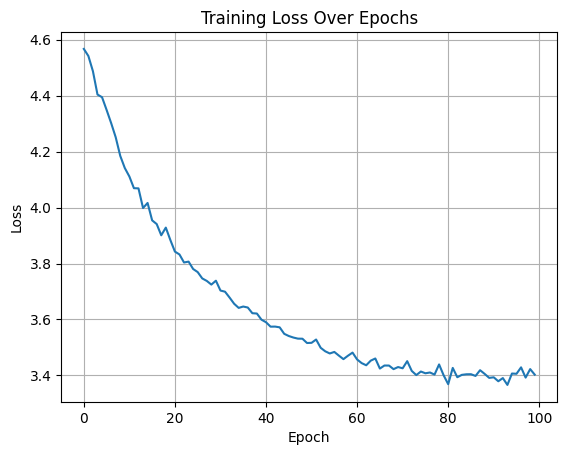

✅ Plot saved as training_loss.png


In [64]:
plt.plot(losses)

plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.savefig(f"{model_name}.png")
plt.show()
print("✅ Plot saved as training_loss.png")

In [49]:
!ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Models	      NLPHW3_JINA.ipynb		      dataset.zip     products.json
NLPHW3.ipynb  clip_lora_adapters_100e16r.png  product_images


In [65]:
!zip -r clip_lora_adapters_100e8r.zip "./Models/clip_lora_adapters_100e8r"
!zip -r clip_lora_adapters_100e8r_ES.zip "./Models/clip_lora_adapters_100e8r_ES"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: Models/clip_lora_adapters_100e8r/ (stored 0%)
  adding: Models/clip_lora_adapters_100e8r/README.md (deflated 66%)
  adding: Models/clip_lora_adapters_100e8r/adapter_config.json (deflated 56%)
  adding: Models/clip_lora_adapters_100e8r/adapter_model.safetensors (deflated 7%)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: Models/clip_lora_adapters_100e8r_ES/ (stored 0%)
  adding: Models/clip_lora_adapters_100e8r_ES/clip_lora_adapters_100e8r_30eCut/ (stored 0%)
  adding: Models/clip_lora_adapters_100e8r_ES/clip_lora_adapters_100e8r_30eCut/README.md (deflated 66%)
  adding: Models/clip_lora_adapters_100e8r_ES/clip_lora_adapters_100e8r_30eCut/adapter_config.json (deflated 56%)
  adding: Models/clip_lora_adapters_100e8r_ES/clip_lora_adapters_100e8r_30eCut/adapter_model.safetensors (deflated 7%)
  adding: Models/clip_lora_adapters_100e8r_ES/clip_lora_adapters_100e8r_70eCut/ (stored 0%)
  adding: Models/clip_lora_adapters_100e8r_ES/clip_lora_adapters_100e8r_70eCut/README.md (deflated 66%)
  adding: Models/clip_lora_adapters_100e8r_ES/clip_lora_adapters_100e8r_70eCut/adapter_config.json (deflated 56%)
  adding: Models/clip_lora_adapters_100e8r_ES/clip_lora_adapters_100e8r_70eCut/adapter_model.safetensors (deflated 7%)
  adding: Models/clip_lora_adapters_100e8r_ES/clip_lora_adapters_100e8r_50eCut/ (st